# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import tensorflow as tf

In [2]:
import pickle

def load_pickled_data(file, columns = ['features', 'labels']):
    """
    Loads pickled training and test data.

    Returns
    -------
    A tuple of X_train, y_train and X_test, y_test datasets.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    
    return tuple(map(lambda c: dataset[c], columns))

In [3]:
train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"

X_train, y_train, sizes, positions = load_pickled_data(train_dataset_file, ['features', 'labels', 'sizes', 'coords'])
X_test, y_test = load_pickled_data(test_dataset_file)

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [4]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]

### Original photos

Let's first explore data about original photos. Who knows — maybe we can spot some data correlations with signs positions in the photos or positions across specific sign classes.

Let's first plot histograms of original photos' sizes.

In [ ]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]
sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(sizes[:, 0])
pyplot.title('Original photos\'s widths')
pyplot.xlabel('Width')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(sizes[:, 1])
pyplot.title('Original photos\'s heights')
pyplot.xlabel('Height')
pyplot.ylabel('Photos')

pyplot.show()

Doesn't look too promising — apparently photos are of all different sizes, majority ranging from ~30 to ~150 px both width and height. Actually both histograms looks surprisingly similar, I bet aspect ratios of all photos are close to 1. Let's check it out!

In [ ]:
sizes_figure = pyplot.figure()
axis = sizes_figure.add_subplot(1, 1, 1)
axis.hist(sizes[:, 0]/sizes[:, 1])
pyplot.title('Photos\' aspect ratios distribution')
pyplot.xlabel('Aspect ratio')
pyplot.ylabel('Photos')
pyplot.show()

There you go! Vast majority of original photos had aspect ratio ranging from 0.9 to 1.2, e.g. almost all photos were more or less square.

Let's check how much area of the original image did signs occupy? In other words, to which extent did we have to crop the original photo to get the sign out of it. Again, let's check for both width and height by calculating sign dimensions as fractions of original photo dimensions.

In [ ]:
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]

sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(width_fraction)
pyplot.title('Sign width / original photo width')
pyplot.xlabel('Width fraction')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(height_fraction)
pyplot.title('Sign height / original photo height')
pyplot.xlabel('Height fraction')
pyplot.ylabel('Photos')

pyplot.show()

In [ ]:
from scipy import stats

def print_stats(array, label):
    _, minmax, mean, variance, _, _ = stats.describe(array)
    margin = int((40 - len(label))/2)
    for i in range(margin*2): 
        if i == margin: print(label.upper(), end="")
        print("=", end="")    
    print()

    print("  %-*s %s" % (15, "Min:", str(minmax[0])))
    print("  %-*s %s" % (15, "Max:", str(minmax[1])))
    print("  %-*s %s" % (15, "Mean:", str(mean)))
    print("  %-*s %s" % (15, "Variance:", str(variance)))
    
    print()
    
print_stats(width_fraction, " sign_width / photo_width ")
print_stats(height_fraction, " sign_height / photo_height ")

Not really promising either. All photos had almost nothing but signs in them, for both width and height signs occupied at least half of the dimension, and for majority of samples signs occupied around 75% of the photo.

Now, if we found any uneven distributions in the dataset I would be tempted to try and analyze it on per-class basis. Although for now data looks pretty homogeneous and I doubt there will be any meaningful patterns related to specific classes based on the original samples' images.

### Sample images

Ok, let's check out the sign samples. We will go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

In [ ]:
import random

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")

**Bad news**: Some classes are highly underrepresented. Overall amount of data is disappointing: some classes have as little as 210 samples, this won't be enough for most of the models to generalise well.

**Good news**: There is a room for data augmentation.

Images with some signs are horizontally symmetrical (like **Bumpy road** or **Ahead only**), and can be simply flipped horizontally, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

CNNs have built-in invariance to small translations, scaling and rotations. The training set doesn't seem to contain those deformations, so we will add those in our data augmentation step as well.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In [5]:
from sklearn.utils import shuffle

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    
    Parameters
    ----------
    X     : ndarray
            Dataset array containing feature examples.
    y     : ndarray, optional, defaults to `None`
            Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """

    # Convert to grayscale, e.g. single channel Y
    X = 0.2125 * X[:, :, :, 0] + 0.7154 * X[:, :, :, 1] + 0.0721 * X[:, :, :, 2]
    # Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)

    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(n_classes)[y]
        X, y = shuffle(X, y, random_state = 42)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

In [6]:
from sklearn.cross_validation import train_test_split

# Load pickled data
X_train, y_train = load_pickled_data(train_dataset_file)
X_test, y_test = load_pickled_data(test_dataset_file)

# Preprocess initial data by scaling features, shiffling the data, etc.
X_test, y_test = preprocess_dataset(X_test, y_test)
X_train, y_train = preprocess_dataset(X_train, y_train)

# Use 20% of the training dataset for validation.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

print("Number of training examples =", y_train.shape[0])
print("Number of validation examples =", y_valid.shape[0])
print("Number of testing examples =", y_test.shape[0])
print("Image data shape =", X_train[0].shape)

/home/alex/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630
Image data shape = (32, 32, 1)


In [7]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma
from skimage.filters import gaussian
import random

class AugmentedSignsBatchIterator(BatchIterator):
    
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped horizontally, should still be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39]
    ])
      
    def __init__(self, batch_size, shuffle = False, seed = 42):
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        
        # Total number of classes    
        num_classes = 43
            
        # Generate a conversion matrix for the one-hot encoded `y` when flipping the image.
        self.y_flip_conversion = np.zeros((num_classes, num_classes))
        self.y_flip_conversion[self.self_flippable, self.self_flippable] = 1.
        self.y_flip_conversion[self.cross_flippable[:, 0], self.cross_flippable[:, 1]] = 1.
        self.y_flip_conversion[self.cross_flippable[:, 1], self.cross_flippable[:, 0]] = 1.
        
        # Create a list of all flippable classes.
        self.flippable = np.append(self.self_flippable, self.cross_flippable.flatten())

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            None if yb is None else yb.copy()
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)
            Xb = self.adjust_gamma(Xb, batch_size)
            Xb = self.blur(Xb, batch_size)
            #Xb = self.add_noise(Xb, batch_size)
            Xb, yb = self.flip_horizontally(Xb, yb, batch_size)

        return Xb, yb
    
    def flip_horizontally(self, Xb, yb, batch_size, p = 0.5):
        """
        Flips random subset of images horizontally, but only those that can either be flipped 
        and would still represent the same class, or those that can represent some other class
        when flipped. In latter case updates batch labels as well.
        """
        # Get a mask of randomly chosen half of elements
        random_choice_indices = np.random.choice(batch_size, int(batch_size * p), replace = False)
        random_choice_mask = np.zeros(batch_size, dtype = bool)
        random_choice_mask[random_choice_indices] = True
        
        # Get a mask of flippable elements in current batch
        flippable_mask = np.in1d(yb.nonzero()[1], self.flippable)
        
        # Get an intersection mask of randomly chosen AND flippable elements
        flip_mask = random_choice_mask & flippable_mask
        
        # Flip images and flip labels as well, if requried. The `y_flip_conversion` is going to take care of that.
        Xb[flip_mask] = Xb[flip_mask, :, ::-1, :]
        yb[flip_mask] = np.transpose(np.dot(self.y_flip_conversion, np.transpose(yb[flip_mask])))
        
        return Xb, yb
        
    def rotate(self, Xb, batch_size, p = 0.5):
        """
        Applies random rotation in range (-15, 15) degrees to a random subset of images.
        """
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = rotate(Xb[i], random.uniform(-15., 15.), mode = 'edge')
        return Xb 
    
    def add_noise(self, Xb, batch_size, p = 0.5):
        """
        Adds random noise to a random subset of images.
        """
        modes = ["gaussian", "localvar", "poisson", "speckle"] # Excluding "salt", "pepper", "s&p" for now
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = random_noise(Xb[i], mode = random.choice(modes))
        return Xb
    
    def adjust_gamma(self, Xb, batch_size, p = 0.5):
        """
        Applies gamma adjustment to a random subset of images, updating gamma with a random value in the (0.5, 1.5) range.
        """
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = adjust_gamma(Xb[i], gamma = random.uniform(0.5, 1.5))
        return Xb        

    def blur(self, Xb, batch_size, p = 0.5):
        """
        Applies gaussian blur with a random sigma in the (0, 0.8) range to a random subset of images.
        """
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):
            Xb[i] = gaussian(Xb[i], sigma = random.uniform(0., 0.8))
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size, p = 0.5):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        of (-10%, +10%) of the image size.
        """
        d = image_size * 0.1
        for i in np.random.choice(batch_size, int(batch_size * p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), mode = 'edge')

        return Xb

/home/alex/bin/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [ ]:
batch_iterator = AugmentedSignsBatchIterator(batch_size = 20)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(20): 
        print("Source class: " + class_name(y_train[i]) + "\n Batch class: " + class_name(y_batch[i]))
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i].reshape(image_size, image_size), cmap='gray')
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i].reshape(image_size, image_size), cmap='gray')
        pyplot.show()
    break

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I convert images to grayscale, scale to `[0, 1]` and shuffle the datasets.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I decided to use a 20% slice of training data for validation. Normally I would split entire dataset as 70% training, 15% validation, 15% testing, but since here test dataset was supplied separately I assumed it's better to use all of it solely for testing.

The dataset looked quite small and some classes were significantly less represented than others, so I reckon the model wouldn't generalise well without additional examples. I decided to use data augmentation by applying randomised transformations while supplying batches of training data to the model. I find Lasagne's `BatchIterator` class very convenient, as one can simply override the `transform()` function and provide their data augmentation pipeline there.

So that's what I did, my pipeline includes:
* **Rotation**. Rotates the image at a random angle in the range of `[-15, 15]` degrees.
* **Projection transform**. Warps the image by projecting each of the image corners to a random point within a 10% of image size distance from the original point.
* **Gamma adjustment**. Adjusts image brightness/contrast by applying gamma adjustment in the range of `[0.5, 1.5]`.
* **Blur**. Applies gaussian blur with sigma in the range of `[0, 0.8]`.
* **Noise**. Adds random noise to the image. I've switched it off for now, but might experiment with it later.
* Last but not least, **horizontal flip**. Flips images horizontally if their class would remain the same, *OR* flips and updates the label, if flipped image represents some other class (e.g. flipped *Turn left* sign would become *Turn right*).

I chose these transformations as they seemed to be close to what we could see on the photos. Image could be blurred and/or noisy due to low resolution source photo, it can be either too bright or too dark depending on the outside conditions, and it can look rotated and/or projection warped on the photo depending on the shooting angle.

General routines

In [8]:
import time

def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

TensorFlow routines

In [30]:
def fully_connected(input, size):
    """
    Performs a single fully connected layer pass, e.g. returns `input * weights + bias`.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def conv_relu(input, kernel_size, depth):
    """
    Performs a single convolution layer pass.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

def pool(input, size):
    """
    Performs a max pooling layer pass.
    """
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )

class EarlyStopping(object):
    def __init__(self, saver, session, patience = 100):
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_loss = np.inf
        self.best_loss_epoch = 0
        self.restore_path = None

    def __call__(self, loss, epoch):
        if loss < self.best_loss:
            self.best_loss = loss
            self.best_loss_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_loss_epoch + self.patience < epoch:
            print("Early stopping.\nBest monitored loss was {:.6f} at epoch {}.".format(
                self.best_loss, self.best_loss_epoch
            ))
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

Model architecture

In [46]:
# Training parameters
batch_size = 36
every_epoch_to_log = 1

# Optimisations
data_augmentation = False
learning_rate_decay = False
momentum_increase = False
dropout = False
l2_reg = False
stage2 = False

# Layers sizes
conv1_k = 5 # 3
conv1_d = 32
conv2_k = 5 # 2
conv2_d = 64
conv3_k = 5 # 2
conv3_d = 128
fc1_size = 1000
fc2_size = 1000

max_epochs = 100

def model_pass(input):
    """
    Performs a full model pass.
    """
    # Convolutions
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = conv1_k, depth = conv1_d) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        if dropout: pool1 = tf.nn.dropout(pool1, keep_prob = 0.9)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = conv2_k, depth = conv2_d)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        if dropout: pool2 = tf.nn.dropout(pool2, keep_prob = 0.8)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = conv3_k, depth = conv3_d)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        if dropout: pool3 = tf.nn.dropout(pool3, keep_prob = 0.7)
    
    # Fully connected
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected(pool3, size = fc1_size)
        if dropout: fc4 = tf.nn.dropout(fc4, keep_prob = 0.5)
#     with tf.variable_scope('fc5'):
#         fc5 = fully_connected(fc4, size = fc2_size)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc4, size = n_classes)
    return prediction

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [32]:
import os

# We will encode model settings in its name: architecture, optimisations applied, etc.
model_name = "k{}d{}_k{}d{}_k{}d{}_fc{}_fc{}".format(conv1_k, conv1_d, conv2_k, conv2_d, conv3_k, conv3_d, fc1_size, fc2_size)
model_name += "_st2" if stage2 else "_no-st2"
model_name += "_aug" if data_augmentation else "_no-aug"
model_name += "_lrdec" if learning_rate_decay else "_no-lrdec"
model_name += "_mominc" if momentum_increase else "_no-mom"
model_name += "_dr" if dropout else "_no-dr"
model_name += "_l2" if l2_reg else "_no-l2"

root_location = os.getcwd() + "/models/"
model_variable_scope = model_name
model_path = root_location + model_name + "/model.ckpt"
train_history_path = root_location + model_name + "/train_history"

os.makedirs(root_location + model_name + "/", exist_ok = True)

In [33]:
graph = tf.Graph()

with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, 1))
    tf_y_batch = tf.placeholder(tf.float32, shape = (None, n_classes))

    current_epoch = tf.Variable(0)  # count the number of epochs

    # Model parameters.
    learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = max_epochs, decay_rate = 0.03) if learning_rate_decay else 0.001
    momentum = 0.9 + (0.99 - 0.9) * (current_epoch / max_epochs) if momentum_increase else 0.99
    
    # Training computation.
    with tf.variable_scope(model_variable_scope):
        logits = model_pass(tf_x_batch)
        if l2_reg:
            with tf.variable_scope('fc4'):
                l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))
#             with tf.variable_scope('fc5'):
#                 l2_loss += tf.nn.l2_loss(tf.get_variable('weights'))   
        else:
            l2_loss = 0
    
    predictions = tf.nn.softmax(logits)
    softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, tf_y_batch)
    loss = tf.reduce_mean(softmax_cross_entropy) + 0.1 * l2_loss  
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer(
        learning_rate = learning_rate
    ).minimize(loss)

In [47]:
start = time.time()

def get_accuracy_and_loss_in_batches(X, y, session):
    p = []
    sce = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, y_batch in batch_iterator(X, y):
        [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], feed_dict = {
                tf_x_batch : x_batch, 
                tf_y_batch : y_batch
            }
        )
        p.extend(p_batch)
        sce.extend(sce_batch)
    p = np.array(p)
    sce = np.array(sce)
    accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
    loss = np.mean(sce)
    return (accuracy, loss)

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    early_stopping = EarlyStopping(tf.train.Saver(), session)
    train_loss_history = np.zeros(max_epochs)
    valid_loss_history = np.zeros(max_epochs)
    print("================ TRAINING =================")
    for epoch in range(max_epochs):
        current_epoch = epoch
        # Train on whole randomised dataset in batches
        batch_iterator = AugmentedSignsBatchIterator(batch_size = batch_size, shuffle = True) if data_augmentation else BatchIterator(batch_size = batch_size, shuffle = True)
        for x_batch, y_batch in batch_iterator(X_train, y_train):
            session.run([optimizer], feed_dict = {
                    tf_x_batch : x_batch, 
                    tf_y_batch : y_batch
                }
            )

        # Get validation data predictions and log validation loss:
        valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid, session)
        valid_loss_history[epoch] = valid_loss
        
        # If another significant epoch ended, we log our losses.
        if (epoch % every_epoch_to_log == 0):
            # Get training data predictions and log training loss:
            train_accuracy, train_loss = get_accuracy_and_loss_in_batches(X_train, y_train, session)
            train_loss_history[epoch] = train_loss
            
            if (epoch % 10 == 0):
                print("------------- EPOCH %4d/%d -------------" % (epoch, max_epochs))
                print("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                print("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                print("           Time: " + get_time_hhmmss(start))
                
        #if early_stopping(valid_loss, epoch): break
                
    # Evaluate on test dataset.
    test_accuracy, test_loss = get_accuracy_and_loss_in_batches(X_test, y_test, session)
    print("===========================================")
    print(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
    print("Train history file: " + train_history_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
================ TRAINING =================
------------- EPOCH    0/100 -------------
     Train loss: 0.15279397, accuracy: 95.85%
Validation loss: 0.19969362, accuracy: 94.54%
           Time: 00:00:05
------------- EPOCH   10/100 -------------
     Train loss: 0.02330356, accuracy: 99.34%
Validation loss: 0.08805447, accuracy: 98.04%
           Time: 00:00:57
------------- EPOCH   20/100 -------------
     Train loss: 0.00895174, accuracy: 99.75%
Validation loss: 0.08467418, accuracy: 98.88%
           Time: 00:01:49
------------- EPOCH   30/100 -------------
     Train loss: 0.01147394, accuracy: 99.80%
Validation loss: 0.13999698, accuracy: 98.85%
           Time: 00:02:41
------------- EPOCH   40/100 -------------
     Train loss: 0.03500802, accuracy: 99.64%
Validation loss: 0.18844095, accuracy: 98.94%
           Time: 00:03:33
------------- EPOCH   50/100 -------------
     Train loss: 0.03106012, accur

In [50]:
# Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.
def plot_learning_curves(model = model_name, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    model_history = np.load(root_location + model + "/train_history.npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], train_linestyle, linewidth=linewidth, label="train")
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return train_loss[train_loss > 0].shape[0]

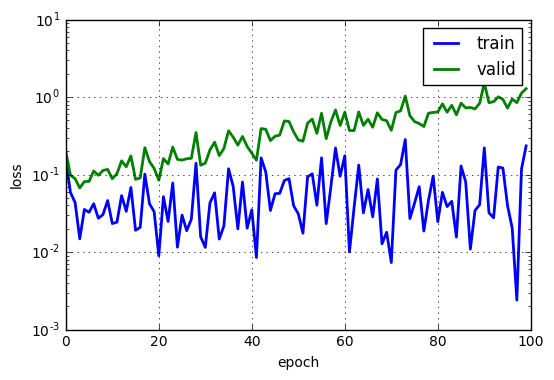

In [53]:
new_model_epochs = plot_learning_curves()
old_model_epochs = 0#plot_learning_curves("3con_2fc_b36_e1000_aug_lrdec_mominc", linewidth = 1)

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.001, 10)
pyplot.xlim(0, max(new_model_epochs, old_model_epochs))
pyplot.yscale("log")
pyplot.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.